# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 16  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7730.52294921875
iteration 0 loss 2690.47265625


iteration 500 loss 87.94657135009766


iteration 1000 loss 45.715484619140625


iteration 1500 loss 3.5966227054595947


iteration 2000 loss 2.152620315551758


iteration 2500 loss 1.5958844423294067


iteration 3000 loss 1.225083827972412


iteration 3500 loss 0.9682233333587646


iteration 4000 loss 0.9871543049812317


iteration 4500 loss 0.828803539276123


iteration 5000 loss 0.7161056995391846


iteration 5500 loss 0.6214817762374878


iteration 6000 loss 0.5365883708000183


iteration 6500 loss 0.5053353905677795


iteration 7000 loss 0.44808536767959595


iteration 7500 loss 0.48722362518310547


iteration 8000 loss 0.4185120463371277


iteration 8500 loss 0.37820965051651


iteration 9000 loss 0.34464114904403687


iteration 9500 loss 0.3498256206512451


iteration 10000 loss 0.31408026814460754


iteration 10500 loss 0.28893399238586426


iteration 11000 loss 0.2966165542602539


iteration 11500 loss 0.26726987957954407


iteration 12000 loss 0.24775400757789612


iteration 12500 loss 0.2595632076263428


iteration 13000 loss 0.23406419157981873


iteration 13500 loss 0.21799519658088684


iteration 14000 loss 0.22755324840545654


iteration 14500 loss 0.2050028294324875


iteration 15000 loss 0.19172757863998413


iteration 15500 loss 0.1924378126859665


iteration 16000 loss 0.17854052782058716


iteration 16500 loss 0.18034833669662476


iteration 17000 loss 0.16492845118045807


iteration 17500 loss 0.16898661851882935


iteration 18000 loss 0.15509139001369476


iteration 18500 loss 0.14652152359485626


iteration 19000 loss 0.15189962089061737


iteration 19500 loss 0.14160573482513428


iteration 20000 loss 0.8101304769515991


iteration 20500 loss 0.1336374133825302


iteration 21000 loss 0.12618926167488098


iteration 21500 loss 0.12835857272148132


iteration 22000 loss 0.12052622437477112


iteration 22500 loss 0.12058494240045547


iteration 23000 loss 0.11271891742944717


iteration 23500 loss 0.1118052750825882


iteration 24000 loss 0.1059940904378891


iteration 24500 loss 0.10600566864013672


iteration 25000 loss 6.676553249359131


iteration 25500 loss 0.1013801172375679


iteration 26000 loss 0.09624390304088593


iteration 26500 loss 0.09795548021793365


iteration 27000 loss 0.09254395216703415


iteration 27500 loss 0.09509655088186264


iteration 28000 loss 0.08905509859323502


iteration 28500 loss 0.09059371799230576


iteration 29000 loss 0.08474944531917572


iteration 29500 loss 0.08529962599277496


iteration 30000 loss 0.08072415739297867


iteration 30500 loss 0.08101687580347061


iteration 31000 loss 1.7464758157730103


iteration 31500 loss 0.07680213451385498


iteration 32000 loss 0.0776369497179985


iteration 32500 loss 0.07308103889226913


iteration 33000 loss 0.0730394721031189


iteration 33500 loss 0.07604216039180756


iteration 34000 loss 0.06967184692621231


iteration 34500 loss 0.07056935876607895


iteration 35000 loss 0.0665336325764656


iteration 35500 loss 0.06643189489841461


iteration 36000 loss 0.0665435940027237


iteration 36500 loss 9.78227710723877


iteration 37000 loss 0.06236371397972107


iteration 37500 loss 0.06201505288481712


iteration 38000 loss 0.06339296698570251


iteration 38500 loss 0.05916547030210495


iteration 39000 loss 0.05916471406817436


iteration 39500 loss 0.059383682906627655


iteration 40000 loss 0.42412692308425903


iteration 40500 loss 0.0556231290102005


iteration 41000 loss 0.05570628494024277


iteration 41500 loss 0.0556788332760334


iteration 42000 loss 0.05688907206058502


iteration 42500 loss 9.674168586730957


iteration 43000 loss 0.05161196365952492


iteration 43500 loss 0.05114314332604408


iteration 44000 loss 0.05014067888259888


iteration 44500 loss 0.04987357556819916


iteration 45000 loss 0.04949309676885605


iteration 45500 loss 0.049253761768341064


iteration 46000 loss 0.04893030598759651


iteration 46500 loss 0.04895962402224541


iteration 47000 loss 0.04691215232014656


iteration 47500 loss 0.04631558433175087


iteration 48000 loss 0.04585753381252289


iteration 48500 loss 0.045650213956832886


iteration 49000 loss 0.043909382075071335


iteration 49500 loss 0.0433790422976017


iteration 50000 loss 10.056183815002441


iteration 50500 loss 0.32321611046791077


iteration 51000 loss 0.2010696977376938


iteration 51500 loss 0.05342722311615944


iteration 52000 loss 0.04261071979999542


iteration 52500 loss 0.040687769651412964


iteration 53000 loss 0.04016917198896408


iteration 53500 loss 0.03953807055950165


iteration 54000 loss 0.038992904126644135


iteration 54500 loss 2.019760847091675


iteration 55000 loss 0.042001280933618546


iteration 55500 loss 0.04375927895307541


iteration 56000 loss 0.04019463434815407


iteration 56500 loss 0.039136819541454315


iteration 57000 loss 0.03836168721318245


iteration 57500 loss 0.03797247260808945


iteration 58000 loss 0.037281617522239685


iteration 58500 loss 0.03645266965031624


iteration 59000 loss 0.03568373620510101


iteration 59500 loss 0.03495842590928078


iteration 60000 loss 0.03443083539605141


iteration 60500 loss 0.21060676872730255


iteration 61000 loss 0.035064779222011566


iteration 61500 loss 0.03407435491681099


iteration 62000 loss 0.03337230905890465


iteration 62500 loss 0.03292234241962433


iteration 63000 loss 0.060951102524995804


iteration 63500 loss 0.03336239978671074


iteration 64000 loss 0.03252611681818962


iteration 64500 loss 0.03182321414351463


iteration 65000 loss 0.03284229338169098


iteration 65500 loss 0.03180801868438721


iteration 66000 loss 0.031092312186956406


iteration 66500 loss 0.032109033316373825


iteration 67000 loss 0.030977660790085793


iteration 67500 loss 0.06965851038694382


iteration 68000 loss 0.030910812318325043


iteration 68500 loss 0.03004981204867363


iteration 69000 loss 0.03116956166923046


iteration 69500 loss 0.02998378872871399


iteration 70000 loss 0.02925526537001133


iteration 70500 loss 0.03172263503074646


iteration 71000 loss 0.0294719859957695


iteration 71500 loss 0.05148395150899887


iteration 72000 loss 0.028590572997927666


iteration 72500 loss 0.028882823884487152


iteration 73000 loss 0.09522821754217148


iteration 73500 loss 0.027912313118577003


iteration 74000 loss 0.028165573254227638


iteration 74500 loss 6.896895408630371


iteration 75000 loss 0.02761146053671837


iteration 75500 loss 0.040661003440618515


iteration 76000 loss 0.0270819254219532


iteration 76500 loss 0.02682681940495968


iteration 77000 loss 0.02667800337076187


iteration 77500 loss 0.027114087715744972


iteration 78000 loss 0.026268478482961655


iteration 78500 loss 0.0267353355884552


iteration 79000 loss 2.0110621452331543


iteration 79500 loss 0.025976620614528656


iteration 80000 loss 0.027211133390665054


iteration 80500 loss 0.025788264349102974


iteration 81000 loss 0.02554638311266899


iteration 81500 loss 0.10418641567230225


iteration 82000 loss 0.03228076547384262


iteration 82500 loss 0.047475364059209824


iteration 83000 loss 0.025025121867656708


iteration 83500 loss 0.025368312373757362


iteration 84000 loss 0.0399564690887928


iteration 84500 loss 0.8135154843330383


iteration 85000 loss 0.02428732067346573


iteration 85500 loss 0.024813944473862648


iteration 86000 loss 0.024061130359768867


iteration 86500 loss 1.39545738697052


iteration 87000 loss 0.2911597788333893


iteration 87500 loss 0.051822543144226074


iteration 88000 loss 1.4326331615447998


iteration 88500 loss 0.09077005088329315


iteration 89000 loss 0.0232638418674469


iteration 89500 loss 0.023109719157218933


iteration 90000 loss 0.2029571384191513


iteration 90500 loss 4.660979270935059


iteration 91000 loss 0.02273174747824669


iteration 91500 loss 0.022915080189704895


iteration 92000 loss 0.02332276478409767


iteration 92500 loss 0.023076361045241356


iteration 93000 loss 0.023795099928975105


iteration 93500 loss 1.894607424736023


iteration 94000 loss 0.17748203873634338


iteration 94500 loss 0.024228960275650024


iteration 95000 loss 0.02208906225860119


iteration 95500 loss 0.26266923546791077


iteration 96000 loss 0.151545450091362


iteration 96500 loss 0.03622293472290039


iteration 97000 loss 0.038754865527153015


iteration 97500 loss 0.02774755470454693


iteration 98000 loss 0.03941311314702034


iteration 98500 loss 0.2500743865966797


iteration 99000 loss 0.036460813134908676


iteration 99500 loss 0.8637301325798035


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.021809762343764305


iteration 100500 loss 0.021013272926211357


iteration 101000 loss 0.020781800150871277


iteration 101500 loss 0.02055426873266697


iteration 102000 loss 0.020325051620602608


iteration 102500 loss 0.02009010687470436


iteration 103000 loss 0.019846972078084946


iteration 103500 loss 0.019594108685851097


iteration 104000 loss 0.0193296167999506


iteration 104500 loss 0.01905088499188423


iteration 105000 loss 0.01879114843904972


iteration 105500 loss 0.018571656197309494


iteration 106000 loss 0.023470262065529823


iteration 106500 loss 0.018212251365184784


iteration 107000 loss 0.037123218178749084


iteration 107500 loss 0.017894448712468147


iteration 108000 loss 0.017745206132531166


iteration 108500 loss 0.017605619505047798


iteration 109000 loss 0.017521502450108528


iteration 109500 loss 0.017347343266010284


iteration 110000 loss 0.017338048666715622


iteration 110500 loss 0.017113445326685905


iteration 111000 loss 0.016994548961520195


iteration 111500 loss 0.016881287097930908


iteration 112000 loss 0.0167769156396389


iteration 112500 loss 0.016702130436897278


iteration 113000 loss 0.016572099179029465


iteration 113500 loss 0.016518207266926765


iteration 114000 loss 0.01649552769958973


iteration 114500 loss 0.016277188435196877


iteration 115000 loss 0.017411278560757637


iteration 115500 loss 0.0163019597530365


iteration 116000 loss 0.016000116243958473


iteration 116500 loss 0.015910256654024124


iteration 117000 loss 0.01582256518304348


iteration 117500 loss 0.015739955008029938


iteration 118000 loss 0.01565892994403839


iteration 118500 loss 0.015571889467537403


iteration 119000 loss 0.015487270429730415


iteration 119500 loss 0.015406508930027485


iteration 120000 loss 0.015332535840570927


iteration 120500 loss 0.015249746851623058


iteration 121000 loss 0.016255991533398628


iteration 121500 loss 0.015368284657597542


iteration 122000 loss 0.01502297818660736


iteration 122500 loss 0.014947749674320221


iteration 123000 loss 0.014873665757477283


iteration 123500 loss 0.014796053990721703


iteration 124000 loss 0.014723101630806923


iteration 124500 loss 0.014654642902314663


iteration 125000 loss 0.014585746452212334


iteration 125500 loss 0.014514334499835968


iteration 126000 loss 0.014448152855038643


iteration 126500 loss 0.014381228014826775


iteration 127000 loss 0.014310147613286972


iteration 127500 loss 0.014247585088014603


iteration 128000 loss 0.014181423000991344


iteration 128500 loss 0.014120377600193024


iteration 129000 loss 0.014078410342335701


iteration 129500 loss 0.013988759368658066


iteration 130000 loss 0.013921720907092094


iteration 130500 loss 0.013860897161066532


iteration 131000 loss 0.01466301828622818


iteration 131500 loss 0.013735132291913033


iteration 132000 loss 0.01367882825434208


iteration 132500 loss 0.013635675422847271


iteration 133000 loss 0.013651711866259575


iteration 133500 loss 0.013505110517144203


iteration 134000 loss 0.024288635700941086


iteration 134500 loss 0.013411177322268486


iteration 135000 loss 0.013336892239749432


iteration 135500 loss 0.01327950693666935


iteration 136000 loss 0.013225202448666096


iteration 136500 loss 0.013173614628612995


iteration 137000 loss 0.01311777625232935


iteration 137500 loss 0.013066214509308338


iteration 138000 loss 0.013011918403208256


iteration 138500 loss 0.012962492182850838


iteration 139000 loss 0.012936619110405445


iteration 139500 loss 0.012853448279201984


iteration 140000 loss 0.012802457436919212


iteration 140500 loss 0.012753292918205261


iteration 141000 loss 0.012746134772896767


iteration 141500 loss 0.012654262594878674


iteration 142000 loss 0.012983212247490883


iteration 142500 loss 0.012556418776512146


iteration 143000 loss 0.012510260567069054


iteration 143500 loss 0.012460860423743725


iteration 144000 loss 0.012415860779583454


iteration 144500 loss 0.012369249016046524


iteration 145000 loss 0.012680643238127232


iteration 145500 loss 0.012507623992860317


iteration 146000 loss 0.05023031309247017


iteration 146500 loss 0.012178991921246052


iteration 147000 loss 0.012135185301303864


iteration 147500 loss 0.012096269987523556


iteration 148000 loss 0.012045633979141712


iteration 148500 loss 0.012002239935100079


iteration 149000 loss 0.011959766037762165


iteration 149500 loss 0.011912437155842781


iteration 150000 loss 0.011871258728206158


iteration 150500 loss 0.01183006726205349


iteration 151000 loss 0.011783820576965809


iteration 151500 loss 0.011746984906494617


iteration 152000 loss 0.030134089291095734


iteration 152500 loss 0.011665882542729378


iteration 153000 loss 0.011626752093434334


iteration 153500 loss 0.011582983657717705


iteration 154000 loss 0.011541920714080334


iteration 154500 loss 0.011945377103984356


iteration 155000 loss 0.0114670405164361


iteration 155500 loss 0.011432252824306488


iteration 156000 loss 0.011381799355149269


iteration 156500 loss 0.011342955753207207


iteration 157000 loss 0.011306251399219036


iteration 157500 loss 0.011267834343016148


iteration 158000 loss 0.011228452436625957


iteration 158500 loss 0.011190191842615604


iteration 159000 loss 0.01115132961422205


iteration 159500 loss 0.011111929081380367


iteration 160000 loss 0.011075343005359173


iteration 160500 loss 0.011041222140192986


iteration 161000 loss 0.01101767923682928


iteration 161500 loss 0.010967794805765152


iteration 162000 loss 0.01093316450715065


iteration 162500 loss 0.010894307866692543


iteration 163000 loss 0.010861828923225403


iteration 163500 loss 0.010824625380337238


iteration 164000 loss 0.01078817155212164


iteration 164500 loss 0.010755314491689205


iteration 165000 loss 0.010718856006860733


iteration 165500 loss 0.010811204090714455


iteration 166000 loss 0.01064892578870058


iteration 166500 loss 0.010615663602948189


iteration 167000 loss 0.011434133164584637


iteration 167500 loss 0.010548771359026432


iteration 168000 loss 0.010514155961573124


iteration 168500 loss 0.010483881458640099


iteration 169000 loss 0.010458896867930889


iteration 169500 loss 0.010423371568322182


iteration 170000 loss 0.010383611544966698


iteration 170500 loss 0.010352044366300106


iteration 171000 loss 0.010318979620933533


iteration 171500 loss 0.010286055505275726


iteration 172000 loss 0.010356158949434757


iteration 172500 loss 0.010222410783171654


iteration 173000 loss 0.010192232206463814


iteration 173500 loss 0.010162722319364548


iteration 174000 loss 0.014186348766088486


iteration 174500 loss 0.01010055560618639


iteration 175000 loss 0.01007175724953413


iteration 175500 loss 0.010055133141577244


iteration 176000 loss 0.010011403821408749


iteration 176500 loss 0.010015154257416725


iteration 177000 loss 0.011142502538859844


iteration 177500 loss 0.009921198710799217


iteration 178000 loss 0.009891004301607609


iteration 178500 loss 0.009864111430943012


iteration 179000 loss 0.010275909677147865


iteration 179500 loss 0.010105546563863754


iteration 180000 loss 0.009776828810572624


iteration 180500 loss 0.009750303812325


iteration 181000 loss 0.07109688967466354


iteration 181500 loss 0.009691265411674976


iteration 182000 loss 0.04954654350876808


iteration 182500 loss 0.021622899919748306


iteration 183000 loss 0.009607654064893723


iteration 183500 loss 0.009580475278198719


iteration 184000 loss 0.009552153758704662


iteration 184500 loss 0.009524485096335411


iteration 185000 loss 0.009496768936514854


iteration 185500 loss 0.00947226956486702


iteration 186000 loss 0.009448494762182236


iteration 186500 loss 0.009608634747564793


iteration 187000 loss 0.009397648274898529


iteration 187500 loss 0.009366539306938648


iteration 188000 loss 0.009339447133243084


iteration 188500 loss 0.009314731694757938


iteration 189000 loss 0.03503553569316864


iteration 189500 loss 0.009264313615858555


iteration 190000 loss 0.009240119718015194


iteration 190500 loss 0.00921657681465149


iteration 191000 loss 0.00918903574347496


iteration 191500 loss 0.009166806004941463


iteration 192000 loss 0.009159206412732601


iteration 192500 loss 0.009115788154304028


iteration 193000 loss 0.009091594256460667


iteration 193500 loss 0.009070243686437607


iteration 194000 loss 0.009042729623615742


iteration 194500 loss 0.010386713780462742


iteration 195000 loss 0.008994029834866524


iteration 195500 loss 0.008970321156084538


iteration 196000 loss 0.009649214334785938


iteration 196500 loss 0.008924392983317375


iteration 197000 loss 0.008899534121155739


iteration 197500 loss 0.00887642428278923


iteration 198000 loss 0.008853761479258537


iteration 198500 loss 0.00935402512550354


iteration 199000 loss 0.008807196281850338


iteration 199500 loss 0.008786380290985107


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.008772752247750759


iteration 200500 loss 0.00876266323029995


iteration 201000 loss 0.008758338168263435


iteration 201500 loss 0.008753733709454536


iteration 202000 loss 0.008748452179133892


iteration 202500 loss 0.008742030709981918


iteration 203000 loss 0.00873402040451765


iteration 203500 loss 0.008723831735551357


iteration 204000 loss 0.008710873313248158


iteration 204500 loss 0.008694303222000599


iteration 205000 loss 0.008677786216139793


iteration 205500 loss 0.008651318028569221


iteration 206000 loss 0.008632044307887554


iteration 206500 loss 0.008611924014985561


iteration 207000 loss 0.008625105023384094


iteration 207500 loss 0.008570963516831398


iteration 208000 loss 0.008551417849957943


iteration 208500 loss 0.008527598343789577


iteration 209000 loss 0.008510289713740349


iteration 209500 loss 0.008492706343531609


iteration 210000 loss 0.008470411412417889


iteration 210500 loss 0.008451536297798157


iteration 211000 loss 0.008435155265033245


iteration 211500 loss 0.008414210751652718


iteration 212000 loss 0.008393273688852787


iteration 212500 loss 0.00837674643844366


iteration 213000 loss 0.008355642668902874


iteration 213500 loss 0.008335016667842865


iteration 214000 loss 0.008320755325257778


iteration 214500 loss 0.008302607573568821


iteration 215000 loss 0.008279739879071712


iteration 215500 loss 0.008263683877885342


iteration 216000 loss 0.00824690517038107


iteration 216500 loss 0.008233752101659775


iteration 217000 loss 0.008208217099308968


iteration 217500 loss 0.00819207914173603


iteration 218000 loss 0.008171482011675835


iteration 218500 loss 0.008153103291988373


iteration 219000 loss 0.008137383498251438


iteration 219500 loss 0.008117313496768475


iteration 220000 loss 0.00809975154697895


iteration 220500 loss 0.008082426153123379


iteration 221000 loss 0.008064283058047295


iteration 221500 loss 0.008046113885939121


iteration 222000 loss 0.00802688580006361


iteration 222500 loss 0.008007312193512917


iteration 223000 loss 0.007993589155375957


iteration 223500 loss 0.007976093329489231


iteration 224000 loss 0.00795749295502901


iteration 224500 loss 0.007940550334751606


iteration 225000 loss 0.007919039577245712


iteration 225500 loss 0.007905673235654831


iteration 226000 loss 0.007890461944043636


iteration 226500 loss 0.007871028035879135


iteration 227000 loss 0.007855714298784733


iteration 227500 loss 0.007840772159397602


iteration 228000 loss 0.007822195068001747


iteration 228500 loss 0.007806364446878433


iteration 229000 loss 0.007792042102664709


iteration 229500 loss 0.007774628233164549


iteration 230000 loss 0.0077575501054525375


iteration 230500 loss 0.007742634974420071


iteration 231000 loss 0.007723549380898476


iteration 231500 loss 0.007709294557571411


iteration 232000 loss 0.007693306542932987


iteration 232500 loss 0.007675257511436939


iteration 233000 loss 0.007661986164748669


iteration 233500 loss 0.007648642640560865


iteration 234000 loss 0.007628998719155788


iteration 234500 loss 0.007612545043230057


iteration 235000 loss 0.007595352362841368


iteration 235500 loss 0.007582512684166431


iteration 236000 loss 0.007566144689917564


iteration 236500 loss 0.007548853754997253


iteration 237000 loss 0.007536230608820915


iteration 237500 loss 0.007520128041505814


iteration 238000 loss 0.007504409644752741


iteration 238500 loss 0.0074897450394928455


iteration 239000 loss 0.007500816136598587


iteration 239500 loss 0.0074596283957362175


iteration 240000 loss 0.0074443938210606575


iteration 240500 loss 0.007427410688251257


iteration 241000 loss 0.007414752151817083


iteration 241500 loss 0.007398721296340227


iteration 242000 loss 0.0073830923065543175


iteration 242500 loss 0.007371589541435242


iteration 243000 loss 0.00735693471506238


iteration 243500 loss 0.007340749725699425


iteration 244000 loss 0.007328472100198269


iteration 244500 loss 0.007312856148928404


iteration 245000 loss 0.007298331707715988


iteration 245500 loss 0.0072841951623559


iteration 246000 loss 0.0072686136700212955


iteration 246500 loss 0.007255469914525747


iteration 247000 loss 0.007242303341627121


iteration 247500 loss 0.007260209880769253


iteration 248000 loss 0.007213045377284288


iteration 248500 loss 0.0071972510777413845


iteration 249000 loss 0.0071832770481705666


iteration 249500 loss 0.007171965669840574


iteration 250000 loss 0.0071575092151761055


iteration 250500 loss 0.007143151015043259


iteration 251000 loss 0.007131032180041075


iteration 251500 loss 0.007115663029253483


iteration 252000 loss 0.007102049887180328


iteration 252500 loss 0.007091382052749395


iteration 253000 loss 0.007078038528561592


iteration 253500 loss 0.007063308730721474


iteration 254000 loss 0.007050763349980116


iteration 254500 loss 0.007035037502646446


iteration 255000 loss 0.0070233517326414585


iteration 255500 loss 0.007011665962636471


iteration 256000 loss 0.0069967336021363735


iteration 256500 loss 0.0069846222177147865


iteration 257000 loss 0.006971282884478569


iteration 257500 loss 0.006956780795007944


iteration 258000 loss 0.006946114357560873


iteration 258500 loss 0.006933785509318113


iteration 259000 loss 0.006918140687048435


iteration 259500 loss 0.006908372975885868


iteration 260000 loss 0.0068970778957009315


iteration 260500 loss 0.006885922513902187


iteration 261000 loss 0.006870565935969353


iteration 261500 loss 0.006855520885437727


iteration 262000 loss 0.006845118477940559


iteration 262500 loss 0.006833348888903856


iteration 263000 loss 0.006819101050496101


iteration 263500 loss 0.0068079326301813126


iteration 264000 loss 0.006795092020183802


iteration 264500 loss 0.006791889667510986


iteration 265000 loss 0.00677146203815937


iteration 265500 loss 0.006760668009519577


iteration 266000 loss 0.006746840663254261


iteration 266500 loss 0.0067359101958572865


iteration 267000 loss 0.006725243758410215


iteration 267500 loss 0.006711731199175119


iteration 268000 loss 0.006700207479298115


iteration 268500 loss 0.006690121255815029


iteration 269000 loss 0.006677302066236734


iteration 269500 loss 0.006665439810603857


iteration 270000 loss 0.006653063930571079


iteration 270500 loss 0.006640823557972908


iteration 271000 loss 0.00663032429292798


iteration 271500 loss 0.006617003586143255


iteration 272000 loss 0.0066061741672456264


iteration 272500 loss 0.006593730300664902


iteration 273000 loss 0.006581880152225494


iteration 273500 loss 0.0065714530646800995


iteration 274000 loss 0.006559670902788639


iteration 274500 loss 0.006548183038830757


iteration 275000 loss 0.006536851637065411


iteration 275500 loss 0.006524484138935804


iteration 276000 loss 0.006514506880193949


iteration 276500 loss 0.006502937059849501


iteration 277000 loss 0.006490853149443865


iteration 277500 loss 0.00648142397403717


iteration 278000 loss 0.0064693838357925415


iteration 278500 loss 0.0064583769999444485


iteration 279000 loss 0.006448074709624052


iteration 279500 loss 0.006433923728764057


iteration 280000 loss 0.006425205618143082


iteration 280500 loss 0.0064155044965445995


iteration 281000 loss 0.006403123494237661


iteration 281500 loss 0.00639300374314189


iteration 282000 loss 0.00638075266033411


iteration 282500 loss 0.006371022667735815


iteration 283000 loss 0.0063601951114833355


iteration 283500 loss 0.00634803157299757


iteration 284000 loss 0.006339124403893948


iteration 284500 loss 0.006328007206320763


iteration 285000 loss 0.006315856706351042


iteration 285500 loss 0.006307726725935936


iteration 286000 loss 0.006297680549323559


iteration 286500 loss 0.006286222953349352


iteration 287000 loss 0.006276736501604319


iteration 287500 loss 0.0062652225606143475


iteration 288000 loss 0.00625540129840374


iteration 288500 loss 0.006244076415896416


iteration 289000 loss 0.0062339953146874905


iteration 289500 loss 0.006223991513252258


iteration 290000 loss 0.006468158680945635


iteration 290500 loss 0.006204016972333193


iteration 291000 loss 0.006194986868649721


iteration 291500 loss 0.006182571407407522


iteration 292000 loss 0.00617422116920352


iteration 292500 loss 0.006165340077131987


iteration 293000 loss 0.00615532835945487


iteration 293500 loss 0.006144786719232798


iteration 294000 loss 0.006134628783911467


iteration 294500 loss 0.006123708561062813


iteration 295000 loss 0.006115257740020752


iteration 295500 loss 0.006105658132582903


iteration 296000 loss 0.006094750948250294


iteration 296500 loss 0.006086353678256273


iteration 297000 loss 0.006075847428292036


iteration 297500 loss 0.006065406836569309


iteration 298000 loss 0.006057885475456715


iteration 298500 loss 0.00604841485619545


iteration 299000 loss 0.0060381353832781315


iteration 299500 loss 0.006027998868376017


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.006018437910825014


iteration 300500 loss 0.006017451640218496


iteration 301000 loss 0.006016163155436516


iteration 301500 loss 0.006014491431415081


iteration 302000 loss 0.006012331694364548


iteration 302500 loss 0.006009587086737156


iteration 303000 loss 0.0060060638934373856


iteration 303500 loss 0.00600155396386981


iteration 304000 loss 0.0059957560151815414


iteration 304500 loss 0.0059883748181164265


iteration 305000 loss 0.005978969857096672


iteration 305500 loss 0.005967043340206146


iteration 306000 loss 0.005958343390375376


iteration 306500 loss 0.005950045771896839


iteration 307000 loss 0.0059395236894488335


iteration 307500 loss 0.005928393919020891


iteration 308000 loss 0.00592039292678237


iteration 308500 loss 0.0059101777151227


iteration 309000 loss 0.005898584146052599


iteration 309500 loss 0.005891655571758747


iteration 310000 loss 0.005882812198251486


iteration 310500 loss 0.0058716111816465855


iteration 311000 loss 0.005862726364284754


iteration 311500 loss 0.005853445269167423


iteration 312000 loss 0.005841777194291353


iteration 312500 loss 0.005833472590893507


iteration 313000 loss 0.005824744701385498


iteration 313500 loss 0.005813684780150652


iteration 314000 loss 0.005804693792015314


iteration 314500 loss 0.00579597894102335


iteration 315000 loss 0.005784955807030201


iteration 315500 loss 0.005776179023087025


iteration 316000 loss 0.005767447873950005


iteration 316500 loss 0.005756379570811987


iteration 317000 loss 0.005747988820075989


iteration 317500 loss 0.005739861633628607


iteration 318000 loss 0.005729528144001961


iteration 318500 loss 0.0057202293537557125


iteration 319000 loss 0.005711870267987251


iteration 319500 loss 0.005701225716620684


iteration 320000 loss 0.005693203769624233


iteration 320500 loss 0.005685752257704735


iteration 321000 loss 0.005676305387169123


iteration 321500 loss 0.0056662545539438725


iteration 322000 loss 0.005659095477312803


iteration 322500 loss 0.005650010425597429


iteration 323000 loss 0.005639049224555492


iteration 323500 loss 0.005631934851408005


iteration 324000 loss 0.005623030010610819


iteration 324500 loss 0.0056127808056771755


iteration 325000 loss 0.0056050000712275505


iteration 325500 loss 0.005595133639872074


iteration 326000 loss 0.005586293525993824


iteration 326500 loss 0.0055799325928092


iteration 327000 loss 0.0055718496441841125


iteration 327500 loss 0.005561669357120991


iteration 328000 loss 0.005554089322686195


iteration 328500 loss 0.005546917207539082


iteration 329000 loss 0.005537835881114006


iteration 329500 loss 0.005528181325644255


iteration 330000 loss 0.005520797800272703


iteration 330500 loss 0.005511426366865635


iteration 331000 loss 0.005502721294760704


iteration 331500 loss 0.005495571997016668


iteration 332000 loss 0.00548650324344635


iteration 332500 loss 0.0054770577698946


iteration 333000 loss 0.005470473784953356


iteration 333500 loss 0.005462090950459242


iteration 334000 loss 0.005451824516057968


iteration 334500 loss 0.00544582586735487


iteration 335000 loss 0.005438662599772215


iteration 335500 loss 0.0054295980371534824


iteration 336000 loss 0.005421233829110861


iteration 336500 loss 0.005413797218352556


iteration 337000 loss 0.005404360126703978


iteration 337500 loss 0.005396457388997078


iteration 338000 loss 0.0053893886506557465


iteration 338500 loss 0.0053804414346814156


iteration 339000 loss 0.005372120067477226


iteration 339500 loss 0.005365133751183748


iteration 340000 loss 0.005356269422918558


iteration 340500 loss 0.0053476993925869465


iteration 341000 loss 0.005340936128050089


iteration 341500 loss 0.0053323861211538315


iteration 342000 loss 0.005324076395481825


iteration 342500 loss 0.0053178854286670685


iteration 343000 loss 0.005310029722750187


iteration 343500 loss 0.0053011211566627026


iteration 344000 loss 0.005294634494930506


iteration 344500 loss 0.005287293344736099


iteration 345000 loss 0.005278049502521753


iteration 345500 loss 0.005271574482321739


iteration 346000 loss 0.0052645327523350716


iteration 346500 loss 0.005255612079054117


iteration 347000 loss 0.00524876406416297


iteration 347500 loss 0.005242424085736275


iteration 348000 loss 0.005234397016465664


iteration 348500 loss 0.005225775763392448


iteration 349000 loss 0.00522009190171957


iteration 349500 loss 0.005212822929024696


iteration 350000 loss 0.005203680135309696


iteration 350500 loss 0.0051974221132695675


iteration 351000 loss 0.005189962685108185


iteration 351500 loss 0.005182832945138216


iteration 352000 loss 0.005174839403480291


iteration 352500 loss 0.005167495459318161


iteration 353000 loss 0.0051593598909676075


iteration 353500 loss 0.0051526776514947414


iteration 354000 loss 0.005145530682057142


iteration 354500 loss 0.005136535037308931


iteration 355000 loss 0.005130930803716183


iteration 355500 loss 0.005124795716255903


iteration 356000 loss 0.005116983782500029


iteration 356500 loss 0.005109172780066729


iteration 357000 loss 0.005102883093059063


iteration 357500 loss 0.0050949170254170895


iteration 358000 loss 0.0050873649306595325


iteration 358500 loss 0.005080787930637598


iteration 359000 loss 0.005072467494755983


iteration 359500 loss 0.005065636709332466


iteration 360000 loss 0.0050597707740962505


iteration 360500 loss 0.0050523304380476475


iteration 361000 loss 0.005044060759246349


iteration 361500 loss 0.0050389752723276615


iteration 362000 loss 0.005032496992498636


iteration 362500 loss 0.0050243050791323185


iteration 363000 loss 0.005017845891416073


iteration 363500 loss 0.005012120120227337


iteration 364000 loss 0.005004847422242165


iteration 364500 loss 0.004996490199118853


iteration 365000 loss 0.0049911304377019405


iteration 365500 loss 0.004984313156455755


iteration 366000 loss 0.004975757095962763


iteration 366500 loss 0.004970920737832785


iteration 367000 loss 0.004965147003531456


iteration 367500 loss 0.004957800731062889


iteration 368000 loss 0.00495039252564311


iteration 368500 loss 0.004944844637066126


iteration 369000 loss 0.004937790334224701


iteration 369500 loss 0.004929829388856888


iteration 370000 loss 0.004924535285681486


iteration 370500 loss 0.004917789716273546


iteration 371000 loss 0.004909830167889595


iteration 371500 loss 0.004904923494905233


iteration 372000 loss 0.004898840095847845


iteration 372500 loss 0.004891158081591129


iteration 373000 loss 0.004884948953986168


iteration 373500 loss 0.004879160784184933


iteration 374000 loss 0.004871799610555172


iteration 374500 loss 0.00486534321680665


iteration 375000 loss 0.004860416520386934


iteration 375500 loss 0.004854131955653429


iteration 376000 loss 0.004846218973398209


iteration 376500 loss 0.0048409802839159966


iteration 377000 loss 0.004835163243114948


iteration 377500 loss 0.004827824886888266


iteration 378000 loss 0.004821843467652798


iteration 378500 loss 0.004816596396267414


iteration 379000 loss 0.00480991555377841


iteration 379500 loss 0.004802623763680458


iteration 380000 loss 0.004797511734068394


iteration 380500 loss 0.004791031125932932


iteration 381000 loss 0.004783185664564371


iteration 381500 loss 0.0047787087969481945


iteration 382000 loss 0.004773044493049383


iteration 382500 loss 0.004765883553773165


iteration 383000 loss 0.004760059528052807


iteration 383500 loss 0.004755240865051746


iteration 384000 loss 0.004749084357172251


iteration 384500 loss 0.004741337615996599


iteration 385000 loss 0.004736755043268204


iteration 385500 loss 0.004731145221740007


iteration 386000 loss 0.004724068101495504


iteration 386500 loss 0.004718281328678131


iteration 387000 loss 0.0047131613828241825


iteration 387500 loss 0.004706664010882378


iteration 388000 loss 0.004699828568845987


iteration 388500 loss 0.004695491399616003


iteration 389000 loss 0.004689971916377544


iteration 389500 loss 0.004682937636971474


iteration 390000 loss 0.0046773855574429035


iteration 390500 loss 0.004671778064221144


iteration 391000 loss 0.004664677660912275


iteration 391500 loss 0.004659651778638363


iteration 392000 loss 0.004654501564800739


iteration 392500 loss 0.004647945519536734


iteration 393000 loss 0.00464163301512599


iteration 393500 loss 0.004637564066797495


iteration 394000 loss 0.004632357973605394


iteration 394500 loss 0.004625759087502956


iteration 395000 loss 0.004620108287781477


iteration 395500 loss 0.004615160170942545


iteration 396000 loss 0.004608888644725084


iteration 396500 loss 0.00460245693102479


iteration 397000 loss 0.004598368424922228


iteration 397500 loss 0.004593150690197945


iteration 398000 loss 0.004586526658385992


iteration 398500 loss 0.004581015091389418


iteration 399000 loss 0.004576551262289286


iteration 399500 loss 0.004570858087390661


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.004563696216791868


iteration 400500 loss 0.004562810994684696


iteration 401000 loss 0.004561692476272583


iteration 401500 loss 0.004560241010040045


iteration 402000 loss 0.004558416083455086


iteration 402500 loss 0.004556175787001848


iteration 403000 loss 0.004553420003503561


iteration 403500 loss 0.004550077486783266


iteration 404000 loss 0.004546093754470348


iteration 404500 loss 0.004541424568742514


iteration 405000 loss 0.004536050837486982


iteration 405500 loss 0.0045307474210858345


iteration 406000 loss 0.004525313153862953


iteration 406500 loss 0.004519893322139978


iteration 407000 loss 0.00451452424749732


iteration 407500 loss 0.004509169142693281


iteration 408000 loss 0.004503845237195492


iteration 408500 loss 0.004498491995036602


iteration 409000 loss 0.004493155516684055


iteration 409500 loss 0.00448784651234746


iteration 410000 loss 0.0044825440272688866


iteration 410500 loss 0.00447726808488369


iteration 411000 loss 0.004471980966627598


iteration 411500 loss 0.004466766957193613


iteration 412000 loss 0.004461532458662987


iteration 412500 loss 0.004456310532987118


iteration 413000 loss 0.00445109698921442


iteration 413500 loss 0.004445912782102823


iteration 414000 loss 0.004440719727426767


iteration 414500 loss 0.0044355206191539764


iteration 415000 loss 0.004430348984897137


iteration 415500 loss 0.004425221588462591


iteration 416000 loss 0.004420115612447262


iteration 416500 loss 0.004415048286318779


iteration 417000 loss 0.004409930668771267


iteration 417500 loss 0.0044048079289495945


iteration 418000 loss 0.004399737808853388


iteration 418500 loss 0.004394700285047293


iteration 419000 loss 0.004389626905322075


iteration 419500 loss 0.004384579602628946


iteration 420000 loss 0.00437950948253274


iteration 420500 loss 0.0043744794093072414


iteration 421000 loss 0.004369500558823347


iteration 421500 loss 0.004364494699984789


iteration 422000 loss 0.004359523765742779


iteration 422500 loss 0.0043545314110815525


iteration 423000 loss 0.0043495469726622105


iteration 423500 loss 0.004344590473920107


iteration 424000 loss 0.004339646082371473


iteration 424500 loss 0.004334696568548679


iteration 425000 loss 0.0043297698721289635


iteration 425500 loss 0.004324853420257568


iteration 426000 loss 0.004319930914789438


iteration 426500 loss 0.004315024707466364


iteration 427000 loss 0.0043101259507238865


iteration 427500 loss 0.004305247217416763


iteration 428000 loss 0.004300370812416077


iteration 428500 loss 0.0042955209501087666


iteration 429000 loss 0.004290652461349964


iteration 429500 loss 0.004285861272364855


iteration 430000 loss 0.004281019791960716


iteration 430500 loss 0.004276201128959656


iteration 431000 loss 0.004271388985216618


iteration 431500 loss 0.004266574513167143


iteration 432000 loss 0.004261803813278675


iteration 432500 loss 0.004257052671164274


iteration 433000 loss 0.004252275917679071


iteration 433500 loss 0.004247513134032488


iteration 434000 loss 0.004242795519530773


iteration 434500 loss 0.00423804298043251


iteration 435000 loss 0.004233327228575945


iteration 435500 loss 0.004228612873703241


iteration 436000 loss 0.004223914816975594


iteration 436500 loss 0.00421921256929636


iteration 437000 loss 0.0042145405896008015


iteration 437500 loss 0.004209855105727911


iteration 438000 loss 0.004205197561532259


iteration 438500 loss 0.004200540948659182


iteration 439000 loss 0.004195915535092354


iteration 439500 loss 0.004191262647509575


iteration 440000 loss 0.004186633042991161


iteration 440500 loss 0.004182004369795322


iteration 441000 loss 0.0041774059645831585


iteration 441500 loss 0.004172805231064558


iteration 442000 loss 0.00416822824627161


iteration 442500 loss 0.004163672216236591


iteration 443000 loss 0.004159103147685528


iteration 443500 loss 0.004154545720666647


iteration 444000 loss 0.004149989690631628


iteration 444500 loss 0.004145460203289986


iteration 445000 loss 0.004140933975577354


iteration 445500 loss 0.004136425908654928


iteration 446000 loss 0.004131932742893696


iteration 446500 loss 0.004127422347664833


iteration 447000 loss 0.004122920800000429


iteration 447500 loss 0.004118449054658413


iteration 448000 loss 0.004113986622542143


iteration 448500 loss 0.004109527915716171


iteration 449000 loss 0.00410506734624505


iteration 449500 loss 0.004100619349628687


iteration 450000 loss 0.004096178337931633


iteration 450500 loss 0.004091762471944094


iteration 451000 loss 0.004087341483682394


iteration 451500 loss 0.004082920961081982


iteration 452000 loss 0.004078506492078304


iteration 452500 loss 0.004074119031429291


iteration 453000 loss 0.004069720394909382


iteration 453500 loss 0.004065347369760275


iteration 454000 loss 0.004060976207256317


iteration 454500 loss 0.004056616220623255


iteration 455000 loss 0.004052286967635155


iteration 455500 loss 0.00404795678332448


iteration 456000 loss 0.0040436130948364735


iteration 456500 loss 0.0040393006056547165


iteration 457000 loss 0.004034980200231075


iteration 457500 loss 0.004030655138194561


iteration 458000 loss 0.004026344511657953


iteration 458500 loss 0.004022061824798584


iteration 459000 loss 0.004017774946987629


iteration 459500 loss 0.004013493191450834


iteration 460000 loss 0.004009251482784748


iteration 460500 loss 0.004004976712167263


iteration 461000 loss 0.004000728018581867


iteration 461500 loss 0.003996484912931919


iteration 462000 loss 0.003992261365056038


iteration 462500 loss 0.003988061100244522


iteration 463000 loss 0.003983841277658939


iteration 463500 loss 0.003979617264121771


iteration 464000 loss 0.0039754300378263


iteration 464500 loss 0.003971235826611519


iteration 465000 loss 0.00396704813465476


iteration 465500 loss 0.003962868358939886


iteration 466000 loss 0.003958703484386206


iteration 466500 loss 0.003954541403800249


iteration 467000 loss 0.0039503853768110275


iteration 467500 loss 0.003946229815483093


iteration 468000 loss 0.003942091483622789


iteration 468500 loss 0.00393796106800437


iteration 469000 loss 0.003933836240321398


iteration 469500 loss 0.0039297351613640785


iteration 470000 loss 0.003925617318600416


iteration 470500 loss 0.003921531140804291


iteration 471000 loss 0.003917436581104994


iteration 471500 loss 0.0039133536629378796


iteration 472000 loss 0.003909277264028788


iteration 472500 loss 0.0039052353240549564


iteration 473000 loss 0.0039011521730571985


iteration 473500 loss 0.0038971053436398506


iteration 474000 loss 0.0038930755108594894


iteration 474500 loss 0.0038890645373612642


iteration 475000 loss 0.0038850437849760056


iteration 475500 loss 0.0038810039404779673


iteration 476000 loss 0.00387699156999588


iteration 476500 loss 0.0038729726802557707


iteration 477000 loss 0.0038689926732331514


iteration 477500 loss 0.003864997997879982


iteration 478000 loss 0.003860999131575227


iteration 478500 loss 0.0038570358883589506


iteration 479000 loss 0.003853046102449298


iteration 479500 loss 0.003849081927910447


iteration 480000 loss 0.0038451410364359617


iteration 480500 loss 0.003841217141598463


iteration 481000 loss 0.003837269963696599


iteration 481500 loss 0.0038333346601575613


iteration 482000 loss 0.0038294210098683834


iteration 482500 loss 0.003825495485216379


iteration 483000 loss 0.0038215715903788805


iteration 483500 loss 0.003817660501226783


iteration 484000 loss 0.0038137761875987053


iteration 484500 loss 0.003809889778494835


iteration 485000 loss 0.0038060147780925035


iteration 485500 loss 0.003802121616899967


iteration 486000 loss 0.003798246383666992


iteration 486500 loss 0.0037943932693451643


iteration 487000 loss 0.0037905334029346704


iteration 487500 loss 0.003786679357290268


iteration 488000 loss 0.0037828367203474045


iteration 488500 loss 0.0037789903581142426


iteration 489000 loss 0.003775159828364849


iteration 489500 loss 0.0037713353522121906


iteration 490000 loss 0.0037675180938094854


iteration 490500 loss 0.0037637092173099518


iteration 491000 loss 0.0037599208299070597


iteration 491500 loss 0.0037561168428510427


iteration 492000 loss 0.003752329619601369


iteration 492500 loss 0.003748556599020958


iteration 493000 loss 0.0037447891663759947


iteration 493500 loss 0.003741025924682617


iteration 494000 loss 0.0037372552324086428


iteration 494500 loss 0.0037335052620619535


iteration 495000 loss 0.0037297592498362064


iteration 495500 loss 0.003726022085174918


iteration 496000 loss 0.003722290275618434


iteration 496500 loss 0.003718550084158778


iteration 497000 loss 0.0037148245610296726


iteration 497500 loss 0.0037111297715455294


iteration 498000 loss 0.0037074140273034573


iteration 498500 loss 0.0037037180736660957


iteration 499000 loss 0.0037000260781496763


iteration 499500 loss 0.003696330590173602


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss 187.84605407714844


loss 119.0496826171875


loss 94.07452392578125


loss 83.20137023925781


loss 78.41759490966797


loss 76.47586059570312


loss 75.80863189697266


loss 75.63133239746094


loss 75.59840393066406


loss 75.59459686279297


loss 75.5943603515625


loss 75.59435272216797


loss 75.59435272216797


loss 75.59434509277344


loss 75.59434509277344


loss 75.59435272216797


loss 75.59434509277344


loss 75.59435272216797


loss 75.5943603515625


loss 75.5943603515625


loss 75.59435272216797


loss 75.59434509277344


loss 75.59435272216797


loss 75.59435272216797


loss 75.59435272216797


loss 75.59435272216797


loss 75.59435272216797


loss 75.59434509277344


loss 75.59434509277344


loss 75.59434509277344


loss 75.59435272216797


loss 75.59435272216797


loss 75.59434509277344


loss 75.5943603515625


loss 75.59435272216797


loss 75.5943603515625


loss 75.5943603515625


loss 75.59435272216797


loss 75.59434509277344


loss 75.59435272216797


final mse:  6.274052388732798e-09
max, min: 1.9075453 -2.0580485
loss 187.84605407714844


loss 120.65301513671875


loss 98.08899688720703


loss 89.23822784423828


loss 85.74057006835938


loss 84.4532699584961


loss 84.04641723632812


loss 83.94535827636719


loss 83.92752075195312


loss 83.9255142211914


loss 83.92539978027344


loss 83.9253921508789


loss 83.9253921508789


loss 83.92539978027344


loss 83.92539978027344


loss 83.9253921508789


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.9253921508789


loss 83.92538452148438


loss 83.92538452148438


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.92539978027344


loss 83.9253921508789


loss 83.9253921508789


loss 83.9253921508789


loss 83.9253921508789


loss 83.9253921508789


loss 83.92539978027344


loss 83.9253921508789


loss 83.9253921508789


loss 83.9253921508789


loss 83.92539978027344


final mse:  6.169864175120665e-09
max, min: 1.8952974 -1.8148214


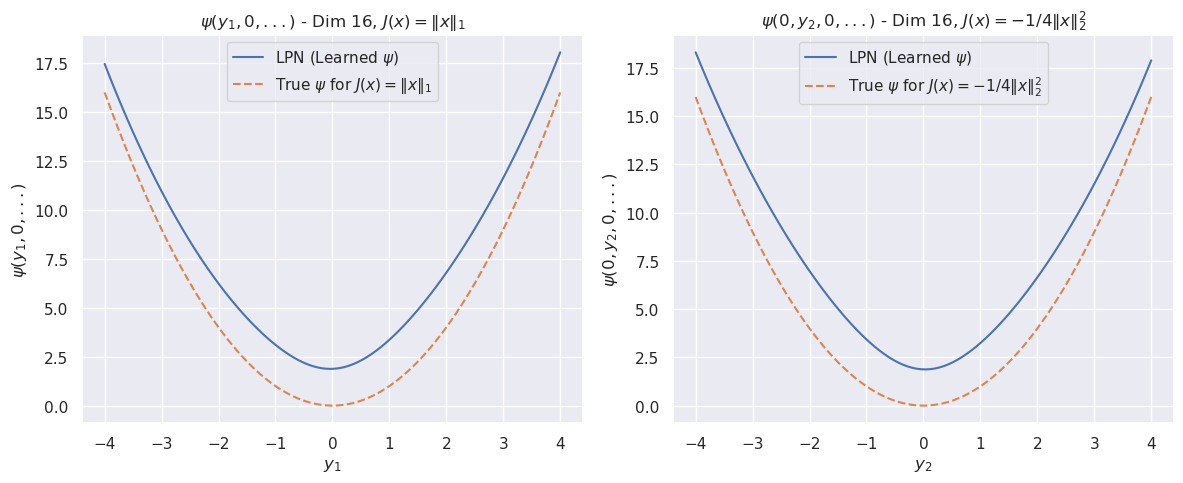

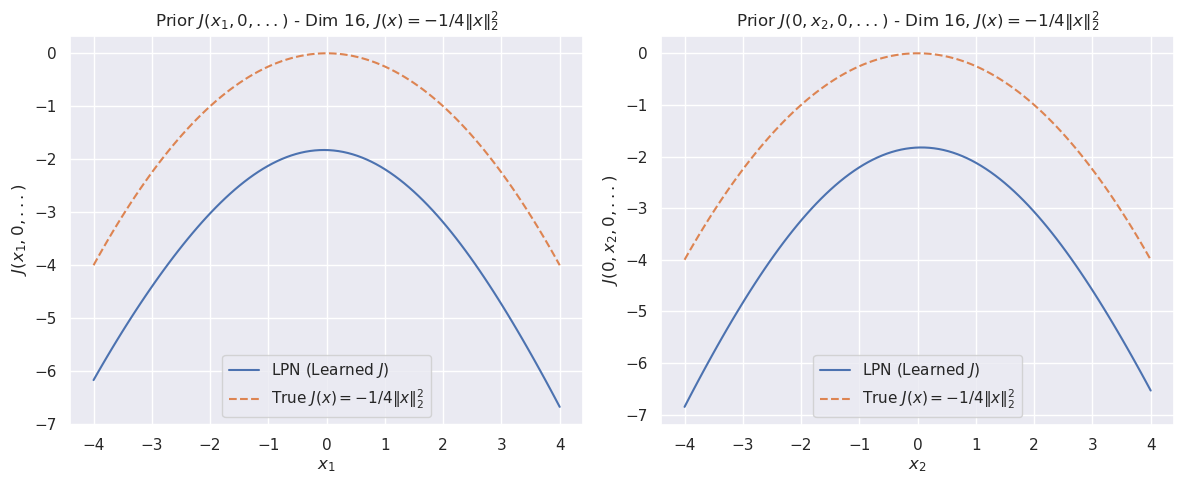

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.2695,  3.2118, -7.9971,  ...,  5.7397, -7.4766,  2.6924],
        [-1.0729,  0.7829, -5.6589,  ...,  5.9787, -6.1046, -1.3711],
        [ 7.5499,  0.6766,  3.4048,  ..., -0.9857,  6.6019, -3.2636],
        ...,
        [-4.4997, -0.3581,  4.2034,  ...,  7.6276, -6.7873, -4.7330],
        [ 3.0656, -1.3299,  5.4502,  ..., -7.7435, -2.4790,  2.8532],
        [ 6.3176, -2.2078, -1.1149,  ..., -7.1331,  3.3589, -0.9447]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7441.38232421875
iteration 0 loss 184.5937957763672


iteration 500 loss 57.07606887817383


iteration 1000 loss 4.011239528656006


iteration 1500 loss 2.1046533584594727


iteration 2000 loss 1.3638836145401


iteration 2500 loss 1.2732865810394287


iteration 3000 loss 0.9554464817047119


iteration 3500 loss 0.7714574933052063


iteration 4000 loss 0.6350697875022888


iteration 4500 loss 0.8497880697250366


iteration 5000 loss 0.6224095225334167


iteration 5500 loss 0.5264959931373596


iteration 6000 loss 0.4593711495399475


iteration 6500 loss 30.116037368774414


iteration 7000 loss 0.40869447588920593


iteration 7500 loss 0.3557966947555542


iteration 8000 loss 0.3943658769130707


iteration 8500 loss 0.3242330849170685


iteration 9000 loss 0.28954318165779114


iteration 9500 loss 0.2761581540107727


iteration 10000 loss 0.3312338590621948


iteration 10500 loss 0.2553972601890564


iteration 11000 loss 0.2301565408706665


iteration 11500 loss 0.2651408016681671


iteration 12000 loss 0.22175060212612152


iteration 12500 loss 0.20151780545711517


iteration 13000 loss 0.21742360293865204


iteration 13500 loss 0.1890171617269516


iteration 14000 loss 52.1031494140625


iteration 14500 loss 0.1766895055770874


iteration 15000 loss 0.16143092513084412


iteration 15500 loss 0.16023626923561096


iteration 16000 loss 0.17871423065662384


iteration 16500 loss 0.14537198841571808


iteration 17000 loss 0.24881383776664734


iteration 17500 loss 0.1423223316669464


iteration 18000 loss 0.13066841661930084


iteration 18500 loss 0.13096608221530914


iteration 19000 loss 4.3637189865112305


iteration 19500 loss 0.11900590360164642


iteration 20000 loss 0.1263747364282608


iteration 20500 loss 0.109573595225811


iteration 21000 loss 0.10853030532598495


iteration 21500 loss 0.12674397230148315


iteration 22000 loss 0.10113014280796051


iteration 22500 loss 0.10660658776760101


iteration 23000 loss 0.09598983079195023


iteration 23500 loss 0.10024570673704147


iteration 24000 loss 0.09050338715314865


iteration 24500 loss 0.09095098078250885


iteration 25000 loss 0.08468139916658401


iteration 25500 loss 0.08549603074789047


iteration 26000 loss 0.08281289786100388


iteration 26500 loss 0.08198604732751846


iteration 27000 loss 0.5157965421676636


iteration 27500 loss 0.07537509500980377


iteration 28000 loss 0.07839177548885345


iteration 28500 loss 0.07214924693107605


iteration 29000 loss 0.07042903453111649


iteration 29500 loss 0.07033832371234894


iteration 30000 loss 0.06813667714595795


iteration 30500 loss 0.06646331399679184


iteration 31000 loss 0.06730794161558151


iteration 31500 loss 0.08019358664751053


iteration 32000 loss 0.06235366314649582


iteration 32500 loss 0.0672462061047554


iteration 33000 loss 0.06037883460521698


iteration 33500 loss 0.05871232971549034


iteration 34000 loss 0.058160025626420975


iteration 34500 loss 0.05622859299182892


iteration 35000 loss 4.372238636016846


iteration 35500 loss 0.05697281286120415


iteration 36000 loss 0.05530679225921631


iteration 36500 loss 0.051876697689294815


iteration 37000 loss 0.050674647092819214


iteration 37500 loss 0.05765722692012787


iteration 38000 loss 0.050602320581674576


iteration 38500 loss 0.04973474144935608


iteration 39000 loss 0.04789821058511734


iteration 39500 loss 0.04685879126191139


iteration 40000 loss 0.0664551854133606


iteration 40500 loss 0.04617629572749138


iteration 41000 loss 0.04516626521945


iteration 41500 loss 0.043915797024965286


iteration 42000 loss 0.043899644166231155


iteration 42500 loss 0.04255145415663719


iteration 43000 loss 0.043635401874780655


iteration 43500 loss 0.041343804448843


iteration 44000 loss 0.047217171639204025


iteration 44500 loss 0.04137188941240311


iteration 45000 loss 0.04008449614048004


iteration 45500 loss 0.04036437347531319


iteration 46000 loss 0.039735179394483566


iteration 46500 loss 0.03847252205014229


iteration 47000 loss 0.03792557120323181


iteration 47500 loss 0.03969864919781685


iteration 48000 loss 6.20211124420166


iteration 48500 loss 0.036567170172929764


iteration 49000 loss 0.050395477563142776


iteration 49500 loss 0.036782406270504


iteration 50000 loss 0.035304199904203415


iteration 50500 loss 0.03989236056804657


iteration 51000 loss 0.03436160460114479


iteration 51500 loss 0.03474213555455208


iteration 52000 loss 0.03509213775396347


iteration 52500 loss 0.0619015209376812


iteration 53000 loss 0.03329315036535263


iteration 53500 loss 0.5365040898323059


iteration 54000 loss 0.03249223902821541


iteration 54500 loss 0.03246181830763817


iteration 55000 loss 0.03181639313697815


iteration 55500 loss 0.03176891803741455


iteration 56000 loss 0.03136912360787392


iteration 56500 loss 0.03187856450676918


iteration 57000 loss 0.05475625768303871


iteration 57500 loss 0.030294954776763916


iteration 58000 loss 0.030247485265135765


iteration 58500 loss 0.030564719811081886


iteration 59000 loss 0.0296497605741024


iteration 59500 loss 0.029618294909596443


iteration 60000 loss 1.1322067975997925


iteration 60500 loss 0.028890658169984818


iteration 61000 loss 0.02909698523581028


iteration 61500 loss 0.028380261734128


iteration 62000 loss 0.19538314640522003


iteration 62500 loss 0.21395741403102875


iteration 63000 loss 0.02968735806643963


iteration 63500 loss 1.6182769536972046


iteration 64000 loss 0.02749643661081791


iteration 64500 loss 0.03228169307112694


iteration 65000 loss 0.028117069974541664


iteration 65500 loss 0.026484455913305283


iteration 66000 loss 0.0266575925052166


iteration 66500 loss 1.1882359981536865


iteration 67000 loss 0.05244959890842438


iteration 67500 loss 1.1089471578598022


iteration 68000 loss 0.057225991040468216


iteration 68500 loss 0.025472892448306084


iteration 69000 loss 0.0883088931441307


iteration 69500 loss 0.02542463317513466


iteration 70000 loss 0.025920120999217033


iteration 70500 loss 0.028308451175689697


iteration 71000 loss 0.02622494287788868


iteration 71500 loss 0.024578509852290154


iteration 72000 loss 0.024770326912403107


iteration 72500 loss 0.024640951305627823


iteration 73000 loss 0.6811387538909912


iteration 73500 loss 0.024478890001773834


iteration 74000 loss 0.024015389382839203


iteration 74500 loss 0.9139918088912964


iteration 75000 loss 0.02378956787288189


iteration 75500 loss 0.4242694675922394


iteration 76000 loss 1.2244893312454224


iteration 76500 loss 0.06295811384916306


iteration 77000 loss 0.0636061280965805


iteration 77500 loss 0.03425278514623642


iteration 78000 loss 0.03589487075805664


iteration 78500 loss 0.024053649976849556


iteration 79000 loss 0.050839196890592575


iteration 79500 loss 0.8680706024169922


iteration 80000 loss 0.91021329164505


iteration 80500 loss 0.025047900155186653


iteration 81000 loss 0.21033869683742523


iteration 81500 loss 0.8924204707145691


iteration 82000 loss 0.023811878636479378


iteration 82500 loss 0.02753721922636032


iteration 83000 loss 0.02317623607814312


iteration 83500 loss 0.02144889533519745


iteration 84000 loss 0.022171875461935997


iteration 84500 loss 0.676366925239563


iteration 85000 loss 0.02633606642484665


iteration 85500 loss 0.021675240248441696


iteration 86000 loss 0.021044734865427017


iteration 86500 loss 0.025922978296875954


iteration 87000 loss 0.08618907630443573


iteration 87500 loss 1.130053997039795


iteration 88000 loss 0.028267424553632736


iteration 88500 loss 0.49518391489982605


iteration 89000 loss 0.020821960642933846


iteration 89500 loss 0.060345619916915894


iteration 90000 loss 0.02027454786002636


iteration 90500 loss 1.049453616142273


iteration 91000 loss 0.021792946383357048


iteration 91500 loss 0.020299647003412247


iteration 92000 loss 0.081578828394413


iteration 92500 loss 0.019997986033558846


iteration 93000 loss 0.019636625424027443


iteration 93500 loss 0.01954001560807228


iteration 94000 loss 0.23542356491088867


iteration 94500 loss 0.02135087177157402


iteration 95000 loss 0.025016073137521744


iteration 95500 loss 0.5420038104057312


iteration 96000 loss 0.0454636812210083


iteration 96500 loss 0.02203313075006008


iteration 97000 loss 0.019364356994628906


iteration 97500 loss 0.019511312246322632


iteration 98000 loss 0.047732219099998474


iteration 98500 loss 0.019397472962737083


iteration 99000 loss 0.01870049722492695


iteration 99500 loss 0.01907290890812874


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.19020520150661469


iteration 100500 loss 0.018772903829813004


iteration 101000 loss 0.018453991040587425


iteration 101500 loss 0.018184617161750793


iteration 102000 loss 0.01793324016034603


iteration 102500 loss 0.01769065298140049


iteration 103000 loss 0.017450854182243347


iteration 103500 loss 0.017209742218255997


iteration 104000 loss 0.01696455478668213


iteration 104500 loss 0.016712652519345284


iteration 105000 loss 0.01647752709686756


iteration 105500 loss 0.02131044678390026


iteration 106000 loss 0.01609739474952221


iteration 106500 loss 0.015949884429574013


iteration 107000 loss 0.015820298343896866


iteration 107500 loss 0.01566183753311634


iteration 108000 loss 0.015541652217507362


iteration 108500 loss 0.01541943196207285


iteration 109000 loss 0.01530036237090826


iteration 109500 loss 0.01518628466874361


iteration 110000 loss 0.015084157697856426


iteration 110500 loss 0.014974145218729973


iteration 111000 loss 0.014873948879539967


iteration 111500 loss 0.01477876864373684


iteration 112000 loss 0.01468875352293253


iteration 112500 loss 0.014598805457353592


iteration 113000 loss 0.014510582201182842


iteration 113500 loss 0.014423809945583344


iteration 114000 loss 0.014339026063680649


iteration 114500 loss 0.01425761915743351


iteration 115000 loss 0.014359408989548683


iteration 115500 loss 0.015580185689032078


iteration 116000 loss 0.014020274393260479


iteration 116500 loss 0.013943316414952278


iteration 117000 loss 0.013868508860468864


iteration 117500 loss 0.013795576989650726


iteration 118000 loss 0.013735702261328697


iteration 118500 loss 0.013668281957507133


iteration 119000 loss 0.013577043078839779


iteration 119500 loss 0.01351284421980381


iteration 120000 loss 0.01344247441738844


iteration 120500 loss 0.013380879536271095


iteration 121000 loss 0.01330937072634697


iteration 121500 loss 0.013243789784610271


iteration 122000 loss 0.013176455162465572


iteration 122500 loss 0.013109477236866951


iteration 123000 loss 0.013053469359874725


iteration 123500 loss 0.012989976443350315


iteration 124000 loss 0.01293010264635086


iteration 124500 loss 0.01287002395838499


iteration 125000 loss 0.012808929197490215


iteration 125500 loss 0.012752323411405087


iteration 126000 loss 0.012695764191448689


iteration 126500 loss 0.012637062929570675


iteration 127000 loss 0.028374720364809036


iteration 127500 loss 0.012524629943072796


iteration 128000 loss 0.012469361536204815


iteration 128500 loss 0.01241719163954258


iteration 129000 loss 0.01583097316324711


iteration 129500 loss 0.012309294193983078


iteration 130000 loss 0.012254700064659119


iteration 130500 loss 0.012208059430122375


iteration 131000 loss 0.014186362735927105


iteration 131500 loss 0.012104040011763573


iteration 132000 loss 0.019829681143164635


iteration 132500 loss 0.012000896967947483


iteration 133000 loss 0.011949656531214714


iteration 133500 loss 0.011902001686394215


iteration 134000 loss 0.011855666525661945


iteration 134500 loss 0.015817580744624138


iteration 135000 loss 0.012727203778922558


iteration 135500 loss 0.011711576022207737


iteration 136000 loss 0.011669991537928581


iteration 136500 loss 0.012952099554240704


iteration 137000 loss 0.011570610105991364


iteration 137500 loss 0.011524410918354988


iteration 138000 loss 0.01148310862481594


iteration 138500 loss 0.011446096003055573


iteration 139000 loss 0.01139390654861927


iteration 139500 loss 0.011351091787219048


iteration 140000 loss 0.012006799690425396


iteration 140500 loss 0.011265210807323456


iteration 141000 loss 0.011221925728023052


iteration 141500 loss 0.011178434826433659


iteration 142000 loss 0.011136842891573906


iteration 142500 loss 0.011097757145762444


iteration 143000 loss 0.011053847149014473


iteration 143500 loss 0.011012459173798561


iteration 144000 loss 0.011874510906636715


iteration 144500 loss 0.010946976952254772


iteration 145000 loss 0.010899320244789124


iteration 145500 loss 0.0108502097427845


iteration 146000 loss 0.010815635323524475


iteration 146500 loss 0.011218754574656487


iteration 147000 loss 0.010737326927483082


iteration 147500 loss 0.010700876824557781


iteration 148000 loss 0.010662984102964401


iteration 148500 loss 0.012169742956757545


iteration 149000 loss 0.010584726929664612


iteration 149500 loss 0.010551048442721367


iteration 150000 loss 0.01051382627338171


iteration 150500 loss 0.010478688403964043


iteration 151000 loss 0.010448543354868889


iteration 151500 loss 0.010515177622437477


iteration 152000 loss 0.010379650630056858


iteration 152500 loss 0.01033347100019455


iteration 153000 loss 0.010299649089574814


iteration 153500 loss 0.010264595970511436


iteration 154000 loss 0.010229839943349361


iteration 154500 loss 0.010351866483688354


iteration 155000 loss 0.010160653851926327


iteration 155500 loss 0.01012906339019537


iteration 156000 loss 0.04083513468503952


iteration 156500 loss 0.01045692153275013


iteration 157000 loss 0.010026940144598484


iteration 157500 loss 0.009993752464652061


iteration 158000 loss 0.01655472442507744


iteration 158500 loss 0.010340114124119282


iteration 159000 loss 0.009918935596942902


iteration 159500 loss 0.009864208288490772


iteration 160000 loss 0.00983586348593235


iteration 160500 loss 0.011507604271173477


iteration 161000 loss 0.009769950062036514


iteration 161500 loss 0.00973881408572197


iteration 162000 loss 0.009733988903462887


iteration 162500 loss 0.00967896543443203


iteration 163000 loss 0.009645315818488598


iteration 163500 loss 0.009653985500335693


iteration 164000 loss 0.009586840867996216


iteration 164500 loss 0.05805082619190216


iteration 165000 loss 0.010249418206512928


iteration 165500 loss 0.009496279060840607


iteration 166000 loss 0.009468304924666882


iteration 166500 loss 0.009543470107018948


iteration 167000 loss 0.009703579358756542


iteration 167500 loss 0.009380747564136982


iteration 168000 loss 0.009353797882795334


iteration 168500 loss 0.009324990212917328


iteration 169000 loss 0.009295724332332611


iteration 169500 loss 0.010562666691839695


iteration 170000 loss 0.009367536753416061


iteration 170500 loss 0.009211492724716663


iteration 171000 loss 0.009185999631881714


iteration 171500 loss 0.01146597322076559


iteration 172000 loss 0.009130981750786304


iteration 172500 loss 0.009104512631893158


iteration 173000 loss 0.00907630380243063


iteration 173500 loss 0.00907847099006176


iteration 174000 loss 0.009025540202856064


iteration 174500 loss 0.009002011269330978


iteration 175000 loss 0.008973431773483753


iteration 175500 loss 0.008946419693529606


iteration 176000 loss 0.00892320740967989


iteration 176500 loss 0.008895833045244217


iteration 177000 loss 0.008870113641023636


iteration 177500 loss 0.008843528106808662


iteration 178000 loss 0.008844226598739624


iteration 178500 loss 0.008793113753199577


iteration 179000 loss 0.008768230676651001


iteration 179500 loss 0.008749283850193024


iteration 180000 loss 0.008723340928554535


iteration 180500 loss 0.00910999532788992


iteration 181000 loss 0.008671736344695091


iteration 181500 loss 0.008647529408335686


iteration 182000 loss 0.008625386282801628


iteration 182500 loss 0.008601773530244827


iteration 183000 loss 0.008576865307986736


iteration 183500 loss 0.012935330159962177


iteration 184000 loss 0.008529492653906345


iteration 184500 loss 0.008504902943968773


iteration 185000 loss 0.008484848774969578


iteration 185500 loss 0.008461520075798035


iteration 186000 loss 0.008437948301434517


iteration 186500 loss 0.010317124426364899


iteration 187000 loss 0.008392397314310074


iteration 187500 loss 0.00837179459631443


iteration 188000 loss 0.008349267765879631


iteration 188500 loss 0.008326954208314419


iteration 189000 loss 0.008305520750582218


iteration 189500 loss 0.009867389686405659


iteration 190000 loss 0.00826086476445198


iteration 190500 loss 0.008239340968430042


iteration 191000 loss 0.008219284936785698


iteration 191500 loss 0.008198092691600323


iteration 192000 loss 0.008175854571163654


iteration 192500 loss 0.00815400667488575


iteration 193000 loss 0.008133557625114918


iteration 193500 loss 0.008191370405256748


iteration 194000 loss 0.008091379888355732


iteration 194500 loss 0.008068883791565895


iteration 195000 loss 0.008932758122682571


iteration 195500 loss 0.008028225041925907


iteration 196000 loss 0.008010735735297203


iteration 196500 loss 0.007987280376255512


iteration 197000 loss 0.007966705597937107


iteration 197500 loss 0.007946694269776344


iteration 198000 loss 0.008015645667910576


iteration 198500 loss 0.007906165905296803


iteration 199000 loss 0.016922002658247948


iteration 199500 loss 0.00786631926894188


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.007870851084589958


iteration 200500 loss 0.007844877429306507


iteration 201000 loss 0.007841609418392181


iteration 201500 loss 0.00783785805106163


iteration 202000 loss 0.007833193987607956


iteration 202500 loss 0.007827261462807655


iteration 203000 loss 0.00781967118382454


iteration 203500 loss 0.007809990551322699


iteration 204000 loss 0.00779758533462882


iteration 204500 loss 0.00778171606361866


iteration 205000 loss 0.0077657136134803295


iteration 205500 loss 0.007742673624306917


iteration 206000 loss 0.007727721240371466


iteration 206500 loss 0.007709117606282234


iteration 207000 loss 0.0076912264339625835


iteration 207500 loss 0.007672649342566729


iteration 208000 loss 0.007654610089957714


iteration 208500 loss 0.007639254909008741


iteration 209000 loss 0.007619499694555998


iteration 209500 loss 0.007602904457598925


iteration 210000 loss 0.007588651496917009


iteration 210500 loss 0.007570537272840738


iteration 211000 loss 0.0075505757704377174


iteration 211500 loss 0.007537464611232281


iteration 212000 loss 0.007536225486546755


iteration 212500 loss 0.007501878775656223


iteration 213000 loss 0.007486722897738218


iteration 213500 loss 0.007467671763151884


iteration 214000 loss 0.007452883291989565


iteration 214500 loss 0.007435752544552088


iteration 215000 loss 0.007418556604534388


iteration 215500 loss 0.007403115276247263


iteration 216000 loss 0.007411281578242779


iteration 216500 loss 0.007370360195636749


iteration 217000 loss 0.007356872782111168


iteration 217500 loss 0.007335906382650137


iteration 218000 loss 0.007322908379137516


iteration 218500 loss 0.007310148328542709


iteration 219000 loss 0.007289906032383442


iteration 219500 loss 0.00728944456204772


iteration 220000 loss 0.007257383316755295


iteration 220500 loss 0.007243583910167217


iteration 221000 loss 0.007225831970572472


iteration 221500 loss 0.007211392279714346


iteration 222000 loss 0.007193651515990496


iteration 222500 loss 0.007179042790085077


iteration 223000 loss 0.007165728136897087


iteration 223500 loss 0.007148771546781063


iteration 224000 loss 0.0071342443116009235


iteration 224500 loss 0.007116744760423899


iteration 225000 loss 0.007103858515620232


iteration 225500 loss 0.007088285405188799


iteration 226000 loss 0.0070715551264584064


iteration 226500 loss 0.007059689611196518


iteration 227000 loss 0.007044687867164612


iteration 227500 loss 0.007029118947684765


iteration 228000 loss 0.007014952600002289


iteration 228500 loss 0.007013393100351095


iteration 229000 loss 0.006986473221331835


iteration 229500 loss 0.0069751134142279625


iteration 230000 loss 0.006955762859433889


iteration 230500 loss 0.006943854968994856


iteration 231000 loss 0.006929573602974415


iteration 231500 loss 0.006914335768669844


iteration 232000 loss 0.0069029675796628


iteration 232500 loss 0.006884908303618431


iteration 233000 loss 0.006872828118503094


iteration 233500 loss 0.0068574645556509495


iteration 234000 loss 0.006843967828899622


iteration 234500 loss 0.00683062756434083


iteration 235000 loss 0.006815710570663214


iteration 235500 loss 0.006804253906011581


iteration 236000 loss 0.006787581834942102


iteration 236500 loss 0.006774113979190588


iteration 237000 loss 0.00675803329795599


iteration 237500 loss 0.0067481487058103085


iteration 238000 loss 0.006736091338098049


iteration 238500 loss 0.006721886340528727


iteration 239000 loss 0.006707743275910616


iteration 239500 loss 0.006692757364362478


iteration 240000 loss 0.0066822003573179245


iteration 240500 loss 0.006677457597106695


iteration 241000 loss 0.006655029486864805


iteration 241500 loss 0.006642209365963936


iteration 242000 loss 0.006655371282249689


iteration 242500 loss 0.006616491824388504


iteration 243000 loss 0.006604806054383516


iteration 243500 loss 0.006600214634090662


iteration 244000 loss 0.0065785800106823444


iteration 244500 loss 0.006565039046108723


iteration 245000 loss 0.006552180275321007


iteration 245500 loss 0.006541230250149965


iteration 246000 loss 0.006537692155689001


iteration 246500 loss 0.006515009794384241


iteration 247000 loss 0.006505211349576712


iteration 247500 loss 0.0064888824708759785


iteration 248000 loss 0.0064782449044287205


iteration 248500 loss 0.0064655328169465065


iteration 249000 loss 0.006452236324548721


iteration 249500 loss 0.006441639736294746


iteration 250000 loss 0.006428103893995285


iteration 250500 loss 0.006416898686438799


iteration 251000 loss 0.006404594983905554


iteration 251500 loss 0.006391903851181269


iteration 252000 loss 0.0063890074379742146


iteration 252500 loss 0.006381078157573938


iteration 253000 loss 0.006355848163366318


iteration 253500 loss 0.006345106288790703


iteration 254000 loss 0.006333624478429556


iteration 254500 loss 0.0063211810775101185


iteration 255000 loss 0.006310759112238884


iteration 255500 loss 0.006296906154602766


iteration 256000 loss 0.006286304444074631


iteration 256500 loss 0.006276482250541449


iteration 257000 loss 0.006269293371587992


iteration 257500 loss 0.006252883467823267


iteration 258000 loss 0.00623999023810029


iteration 258500 loss 0.006229502614587545


iteration 259000 loss 0.006220635026693344


iteration 259500 loss 0.0062074558809399605


iteration 260000 loss 0.006195815745741129


iteration 260500 loss 0.006812314037233591


iteration 261000 loss 0.006172968074679375


iteration 261500 loss 0.006166331935673952


iteration 262000 loss 0.00614895997568965


iteration 262500 loss 0.006140226498246193


iteration 263000 loss 0.006150963716208935


iteration 263500 loss 0.006132674403488636


iteration 264000 loss 0.006107765715569258


iteration 264500 loss 0.00609760032966733


iteration 265000 loss 0.006099688820540905


iteration 265500 loss 0.006075805053114891


iteration 266000 loss 0.006064493674784899


iteration 266500 loss 0.006053800694644451


iteration 267000 loss 0.006043890491127968


iteration 267500 loss 0.006031322758644819


iteration 268000 loss 0.006021258421242237


iteration 268500 loss 0.006014565005898476


iteration 269000 loss 0.006001026835292578


iteration 269500 loss 0.005990555044263601


iteration 270000 loss 0.005978069268167019


iteration 270500 loss 0.005969613790512085


iteration 271000 loss 0.005963514093309641


iteration 271500 loss 0.005947600584477186


iteration 272000 loss 0.005938917398452759


iteration 272500 loss 0.005928799510002136


iteration 273000 loss 0.005917476024478674


iteration 273500 loss 0.005908195860683918


iteration 274000 loss 0.00589638389647007


iteration 274500 loss 0.005887698382139206


iteration 275000 loss 0.005877708084881306


iteration 275500 loss 0.005867074243724346


iteration 276000 loss 0.005856456700712442


iteration 276500 loss 0.005845561157912016


iteration 277000 loss 0.00583759555593133


iteration 277500 loss 0.005827650893479586


iteration 278000 loss 0.005817190743982792


iteration 278500 loss 0.0058072092942893505


iteration 279000 loss 0.005796810146421194


iteration 279500 loss 0.005787800997495651


iteration 280000 loss 0.009013444185256958


iteration 280500 loss 0.005767988972365856


iteration 281000 loss 0.005757392384111881


iteration 281500 loss 0.0057480791583657265


iteration 282000 loss 0.005738697946071625


iteration 282500 loss 0.005728044547140598


iteration 283000 loss 0.005719341803342104


iteration 283500 loss 0.005718449130654335


iteration 284000 loss 0.005699820350855589


iteration 284500 loss 0.005688794422894716


iteration 285000 loss 0.005680788308382034


iteration 285500 loss 0.0056732166558504105


iteration 286000 loss 0.005661078728735447


iteration 286500 loss 0.0056533608585596085


iteration 287000 loss 0.005643588490784168


iteration 287500 loss 0.005634032655507326


iteration 288000 loss 0.005625646561384201


iteration 288500 loss 0.005614733789116144


iteration 289000 loss 0.005606142338365316


iteration 289500 loss 0.005598371382802725


iteration 290000 loss 0.005588528700172901


iteration 290500 loss 0.0055796611122787


iteration 291000 loss 0.005569145083427429


iteration 291500 loss 0.005561519879847765


iteration 292000 loss 0.005552898161113262


iteration 292500 loss 0.005543185863643885


iteration 293000 loss 0.005535521544516087


iteration 293500 loss 0.006349099799990654


iteration 294000 loss 0.00551719730719924


iteration 294500 loss 0.005508969072252512


iteration 295000 loss 0.005499256309121847


iteration 295500 loss 0.005496943835169077


iteration 296000 loss 0.0054812184534966946


iteration 296500 loss 0.005477261263877153


iteration 297000 loss 0.005462817847728729


iteration 297500 loss 0.005455659236758947


iteration 298000 loss 0.00544674601405859


iteration 298500 loss 0.005437630228698254


iteration 299000 loss 0.00543042691424489


iteration 299500 loss 0.005427388474345207


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.005412762984633446


iteration 300500 loss 0.0054118032567203045


iteration 301000 loss 0.005410570185631514


iteration 301500 loss 0.005408954806625843


iteration 302000 loss 0.005406866315752268


iteration 302500 loss 0.0054042162373661995


iteration 303000 loss 0.005400797817856073


iteration 303500 loss 0.0053964355029165745


iteration 304000 loss 0.005390859209001064


iteration 304500 loss 0.005383741110563278


iteration 305000 loss 0.005374683532863855


iteration 305500 loss 0.005363364238291979


iteration 306000 loss 0.005354635883122683


iteration 306500 loss 0.005345799960196018


iteration 307000 loss 0.00533468509092927


iteration 307500 loss 0.005326440092176199


iteration 308000 loss 0.005318874958902597


iteration 308500 loss 0.005309339612722397


iteration 309000 loss 0.0052981446497142315


iteration 309500 loss 0.005290610250085592


iteration 310000 loss 0.005281228572130203


iteration 310500 loss 0.005270136520266533


iteration 311000 loss 0.005263481754809618


iteration 311500 loss 0.005254992749541998


iteration 312000 loss 0.005244333762675524


iteration 312500 loss 0.005235875956714153


iteration 313000 loss 0.005227238871157169


iteration 313500 loss 0.005216371268033981


iteration 314000 loss 0.005208110436797142


iteration 314500 loss 0.005198237020522356


iteration 315000 loss 0.005189064424484968


iteration 315500 loss 0.005182449705898762


iteration 316000 loss 0.005174094345420599


iteration 316500 loss 0.005163612775504589


iteration 317000 loss 0.005156220402568579


iteration 317500 loss 0.00514832790941


iteration 318000 loss 0.005138352047652006


iteration 318500 loss 0.005129758268594742


iteration 319000 loss 0.00512275006622076


iteration 319500 loss 0.005113883875310421


iteration 320000 loss 0.005103296600282192


iteration 320500 loss 0.005096842534840107


iteration 321000 loss 0.00508887879550457


iteration 321500 loss 0.005078824702650309


iteration 322000 loss 0.005070908460766077


iteration 322500 loss 0.0050634900107979774


iteration 323000 loss 0.005054133012890816


iteration 323500 loss 0.0050451080314815044


iteration 324000 loss 0.005038602743297815


iteration 324500 loss 0.005030383355915546


iteration 325000 loss 0.005020104348659515


iteration 325500 loss 0.005013987421989441


iteration 326000 loss 0.005006630904972553


iteration 326500 loss 0.004997418727725744


iteration 327000 loss 0.004988813307136297


iteration 327500 loss 0.00498232152312994


iteration 328000 loss 0.004974148236215115


iteration 328500 loss 0.004995506256818771


iteration 329000 loss 0.004957625176757574


iteration 329500 loss 0.004949747584760189


iteration 330000 loss 0.004939816892147064


iteration 330500 loss 0.004933624528348446


iteration 331000 loss 0.004927155561745167


iteration 331500 loss 0.004918997175991535


iteration 332000 loss 0.004909552168101072


iteration 332500 loss 0.00490326015278697


iteration 333000 loss 0.004895285237580538


iteration 333500 loss 0.0048853433690965176


iteration 334000 loss 0.004879518877714872


iteration 334500 loss 0.0048723770305514336


iteration 335000 loss 0.00486343540251255


iteration 335500 loss 0.004855880979448557


iteration 336000 loss 0.004848922602832317


iteration 336500 loss 0.00484014255926013


iteration 337000 loss 0.004832301288843155


iteration 337500 loss 0.00482558598741889


iteration 338000 loss 0.004817096050828695


iteration 338500 loss 0.004808735102415085


iteration 339000 loss 0.004802340641617775


iteration 339500 loss 0.004794267006218433


iteration 340000 loss 0.004785510245710611


iteration 340500 loss 0.004780487157404423


iteration 341000 loss 0.004774086643010378


iteration 341500 loss 0.004766026511788368


iteration 342000 loss 0.004757764749228954


iteration 342500 loss 0.004752411972731352


iteration 343000 loss 0.004745591897517443


iteration 343500 loss 0.004737020470201969


iteration 344000 loss 0.004730016924440861


iteration 344500 loss 0.004724057856947184


iteration 345000 loss 0.004716530442237854


iteration 345500 loss 0.00476330891251564


iteration 346000 loss 0.004702440463006496


iteration 346500 loss 0.004696497227996588


iteration 347000 loss 0.0046890066005289555


iteration 347500 loss 0.004680398385971785


iteration 348000 loss 0.004675316624343395


iteration 348500 loss 0.0046688769944012165


iteration 349000 loss 0.004660772625356913


iteration 349500 loss 0.004653657786548138


iteration 350000 loss 0.004646959714591503


iteration 350500 loss 0.004638534504920244


iteration 351000 loss 0.004632412921637297


iteration 351500 loss 0.004627146292477846


iteration 352000 loss 0.004620446357876062


iteration 352500 loss 0.004612067248672247


iteration 353000 loss 0.0046057067811489105


iteration 353500 loss 0.004599183332175016


iteration 354000 loss 0.004591019824147224


iteration 354500 loss 0.00458456901833415


iteration 355000 loss 0.004578998778015375


iteration 355500 loss 0.004571944009512663


iteration 356000 loss 0.004563820548355579


iteration 356500 loss 0.004558864515274763


iteration 357000 loss 0.004553026519715786


iteration 357500 loss 0.004545645788311958


iteration 358000 loss 0.004537701606750488


iteration 358500 loss 0.004533198196440935


iteration 359000 loss 0.0045275199227035046


iteration 359500 loss 0.004520229995250702


iteration 360000 loss 0.004512377083301544


iteration 360500 loss 0.00450795516371727


iteration 361000 loss 0.004502326715737581


iteration 361500 loss 0.004495217930525541


iteration 362000 loss 0.004487856291234493


iteration 362500 loss 0.004482786636799574


iteration 363000 loss 0.004476407077163458


iteration 363500 loss 0.004468251951038837


iteration 364000 loss 0.004462768789380789


iteration 364500 loss 0.004456338472664356


iteration 365000 loss 0.004448244348168373


iteration 365500 loss 0.0044431923888623714


iteration 366000 loss 0.004437286406755447


iteration 366500 loss 0.004429800435900688


iteration 367000 loss 0.004423251375555992


iteration 367500 loss 0.004417695105075836


iteration 368000 loss 0.004410645458847284


iteration 368500 loss 0.004403334576636553


iteration 369000 loss 0.004398335702717304


iteration 369500 loss 0.004391987808048725


iteration 370000 loss 0.004384051542729139


iteration 370500 loss 0.004379149992018938


iteration 371000 loss 0.004374315496534109


iteration 371500 loss 0.004368156660348177


iteration 372000 loss 0.004360486753284931


iteration 372500 loss 0.004355359822511673


iteration 373000 loss 0.004349830094724894


iteration 373500 loss 0.004342782776802778


iteration 374000 loss 0.004336283542215824


iteration 374500 loss 0.004331034608185291


iteration 375000 loss 0.0043244194239377975


iteration 375500 loss 0.004316737875342369


iteration 376000 loss 0.0043122731149196625


iteration 376500 loss 0.004306625574827194


iteration 377000 loss 0.004299561493098736


iteration 377500 loss 0.004293503705412149


iteration 378000 loss 0.004288996569812298


iteration 378500 loss 0.0042832824401557446


iteration 379000 loss 0.004276137799024582


iteration 379500 loss 0.004270489327609539


iteration 380000 loss 0.004265257623046637


iteration 380500 loss 0.004258663859218359


iteration 381000 loss 0.004252000246196985


iteration 381500 loss 0.004247746895998716


iteration 382000 loss 0.004242334049195051


iteration 382500 loss 0.004235531203448772


iteration 383000 loss 0.004229710437357426


iteration 383500 loss 0.004224414937198162


iteration 384000 loss 0.004217755515128374


iteration 384500 loss 0.004212017171084881


iteration 385000 loss 0.004207593388855457


iteration 385500 loss 0.004201982170343399


iteration 386000 loss 0.004195141606032848


iteration 386500 loss 0.004190077539533377


iteration 387000 loss 0.004185578320175409


iteration 387500 loss 0.0041798814199864864


iteration 388000 loss 0.004172807559370995


iteration 388500 loss 0.004167989362031221


iteration 389000 loss 0.004162806086242199


iteration 389500 loss 0.004156284499913454


iteration 390000 loss 0.004150369670242071


iteration 390500 loss 0.004145688842982054


iteration 391000 loss 0.0041397493332624435


iteration 391500 loss 0.004132953472435474


iteration 392000 loss 0.004128627944737673


iteration 392500 loss 0.004123139660805464


iteration 393000 loss 0.004116248805075884


iteration 393500 loss 0.004112009424716234


iteration 394000 loss 0.00410758750513196


iteration 394500 loss 0.0041019911877810955


iteration 395000 loss 0.004095166921615601


iteration 395500 loss 0.004090592265129089


iteration 396000 loss 0.004085315857082605


iteration 396500 loss 0.004078368190675974


iteration 397000 loss 0.004074092023074627


iteration 397500 loss 0.004069904796779156


iteration 398000 loss 0.004064591135829687


iteration 398500 loss 0.004057972226291895


iteration 399000 loss 0.00405312143266201


iteration 399500 loss 0.004048449452966452


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0040425206534564495


iteration 400500 loss 0.004041783511638641


iteration 401000 loss 0.004040838684886694


iteration 401500 loss 0.004039649851620197


iteration 402000 loss 0.00403814110904932


iteration 402500 loss 0.004036264959722757


iteration 403000 loss 0.004034001380205154


iteration 403500 loss 0.004031268414109945


iteration 404000 loss 0.004028034396469593


iteration 404500 loss 0.00402428675442934


iteration 405000 loss 0.004020044580101967


iteration 405500 loss 0.004015439655631781


iteration 406000 loss 0.004010814242064953


iteration 406500 loss 0.004006212577223778


iteration 407000 loss 0.0040016137063503265


iteration 407500 loss 0.003997025080025196


iteration 408000 loss 0.0039924378506839275


iteration 408500 loss 0.003987864125519991


iteration 409000 loss 0.003983308561146259


iteration 409500 loss 0.003978768363595009


iteration 410000 loss 0.003974227234721184


iteration 410500 loss 0.003969711717218161


iteration 411000 loss 0.003965201787650585


iteration 411500 loss 0.003960697446018457


iteration 412000 loss 0.003956213127821684


iteration 412500 loss 0.003951724618673325


iteration 413000 loss 0.0039472500793635845


iteration 413500 loss 0.003942801617085934


iteration 414000 loss 0.003938337787985802


iteration 414500 loss 0.003933905158191919


iteration 415000 loss 0.003929470665752888


iteration 415500 loss 0.003925070632249117


iteration 416000 loss 0.0039206612855196


iteration 416500 loss 0.003916249144822359


iteration 417000 loss 0.003911849111318588


iteration 417500 loss 0.003907463978976011


iteration 418000 loss 0.003903099102899432


iteration 418500 loss 0.0038987367879599333


iteration 419000 loss 0.003894374705851078


iteration 419500 loss 0.0038900207728147507


iteration 420000 loss 0.003885698039084673


iteration 420500 loss 0.0038813708815723658


iteration 421000 loss 0.0038770593237131834


iteration 421500 loss 0.003872747765854001


iteration 422000 loss 0.0038684408646076918


iteration 422500 loss 0.0038641507271677256


iteration 423000 loss 0.0038598652463406324


iteration 423500 loss 0.003855582792311907


iteration 424000 loss 0.003851318499073386


iteration 424500 loss 0.003847066080197692


iteration 425000 loss 0.0038428199477493763


iteration 425500 loss 0.003838582197204232


iteration 426000 loss 0.0038343495689332485


iteration 426500 loss 0.0038301199674606323


iteration 427000 loss 0.003825899213552475


iteration 427500 loss 0.003821700345724821


iteration 428000 loss 0.003817508229985833


iteration 428500 loss 0.0038133137859404087


iteration 429000 loss 0.003809125628322363


iteration 429500 loss 0.003804955165833235


iteration 430000 loss 0.0038007909897714853


iteration 430500 loss 0.0037966405507177114


iteration 431000 loss 0.0037924915086477995


iteration 431500 loss 0.0037883471231907606


iteration 432000 loss 0.0037842122837901115


iteration 432500 loss 0.0037800867576152086


iteration 433000 loss 0.003775982651859522


iteration 433500 loss 0.003771866438910365


iteration 434000 loss 0.003767765359953046


iteration 434500 loss 0.0037636759225279093


iteration 435000 loss 0.0037595881149172783


iteration 435500 loss 0.003755507292225957


iteration 436000 loss 0.0037514439318329096


iteration 436500 loss 0.0037473912816494703


iteration 437000 loss 0.0037433309480547905


iteration 437500 loss 0.003739295993000269


iteration 438000 loss 0.0037352622020989656


iteration 438500 loss 0.003731227247044444


iteration 439000 loss 0.0037272057961672544


iteration 439500 loss 0.0037231910973787308


iteration 440000 loss 0.0037191782612353563


iteration 440500 loss 0.0037151772994548082


iteration 441000 loss 0.003711187280714512


iteration 441500 loss 0.003707203781232238


iteration 442000 loss 0.0037032291293144226


iteration 442500 loss 0.0036992474924772978


iteration 443000 loss 0.0036952856462448835


iteration 443500 loss 0.0036913370713591576


iteration 444000 loss 0.00368739222176373


iteration 444500 loss 0.003683455754071474


iteration 445000 loss 0.003679514629766345


iteration 445500 loss 0.003675595624372363


iteration 446000 loss 0.003671671263873577


iteration 446500 loss 0.003667759243398905


iteration 447000 loss 0.0036638479214161634


iteration 447500 loss 0.0036599435843527317


iteration 448000 loss 0.0036560515873134136


iteration 448500 loss 0.003652171930298209


iteration 449000 loss 0.0036482939030975103


iteration 449500 loss 0.0036444144789129496


iteration 450000 loss 0.003640543669462204


iteration 450500 loss 0.0036366847343742847


iteration 451000 loss 0.0036328332498669624


iteration 451500 loss 0.003628989215940237


iteration 452000 loss 0.003625144949182868


iteration 452500 loss 0.0036213158164173365


iteration 453000 loss 0.003617494134232402


iteration 453500 loss 0.0036136689595878124


iteration 454000 loss 0.0036098554264754057


iteration 454500 loss 0.0036060570273548365


iteration 455000 loss 0.00360224861651659


iteration 455500 loss 0.003598457435145974


iteration 456000 loss 0.0035946823190897703


iteration 456500 loss 0.0035908985882997513


iteration 457000 loss 0.003587125800549984


iteration 457500 loss 0.0035833592992275953


iteration 458000 loss 0.0035795920994132757


iteration 458500 loss 0.003575841896235943


iteration 459000 loss 0.0035720879677683115


iteration 459500 loss 0.003568354295566678


iteration 460000 loss 0.0035646138712763786


iteration 460500 loss 0.0035608920734375715


iteration 461000 loss 0.003557175165042281


iteration 461500 loss 0.0035534552298486233


iteration 462000 loss 0.0035497599747031927


iteration 462500 loss 0.003546052146703005


iteration 463000 loss 0.0035423620138317347


iteration 463500 loss 0.00353867094963789


iteration 464000 loss 0.003534991294145584


iteration 464500 loss 0.003531309310346842


iteration 465000 loss 0.0035276468843221664


iteration 465500 loss 0.0035239786375313997


iteration 466000 loss 0.0035203206352889538


iteration 466500 loss 0.0035166714806109667


iteration 467000 loss 0.003513021394610405


iteration 467500 loss 0.003509379457682371


iteration 468000 loss 0.00350574660114944


iteration 468500 loss 0.0035021244548261166


iteration 469000 loss 0.0034984995145350695


iteration 469500 loss 0.0034948873799294233


iteration 470000 loss 0.003491288051009178


iteration 470500 loss 0.0034876784775406122


iteration 471000 loss 0.0034840754233300686


iteration 471500 loss 0.0034804895985871553


iteration 472000 loss 0.0034769002813845873


iteration 472500 loss 0.003473324468359351


iteration 473000 loss 0.0034697619266808033


iteration 473500 loss 0.003466191468760371


iteration 474000 loss 0.003462627762928605


iteration 474500 loss 0.003459078026935458


iteration 475000 loss 0.003455530386418104


iteration 475500 loss 0.003451993688941002


iteration 476000 loss 0.0034484565258026123


iteration 476500 loss 0.003444921923801303


iteration 477000 loss 0.0034413908142596483


iteration 477500 loss 0.003437870880588889


iteration 478000 loss 0.003434348152950406


iteration 478500 loss 0.0034308508038520813


iteration 479000 loss 0.0034273413475602865


iteration 479500 loss 0.003423860762268305


iteration 480000 loss 0.003420361550524831


iteration 480500 loss 0.0034168725833296776


iteration 481000 loss 0.003413386642932892


iteration 481500 loss 0.0034099228214472532


iteration 482000 loss 0.0034064387436956167


iteration 482500 loss 0.0034029667731374502


iteration 483000 loss 0.0033995157573372126


iteration 483500 loss 0.003396071493625641


iteration 484000 loss 0.0033926235046237707


iteration 484500 loss 0.0033891897182911634


iteration 485000 loss 0.0033857550006359816


iteration 485500 loss 0.0033823284320533276


iteration 486000 loss 0.003378908382728696


iteration 486500 loss 0.0033754780888557434


iteration 487000 loss 0.003372063161805272


iteration 487500 loss 0.0033686452079564333


iteration 488000 loss 0.0033652433194220066


iteration 488500 loss 0.0033618370071053505


iteration 489000 loss 0.0033584421034902334


iteration 489500 loss 0.0033550476655364037


iteration 490000 loss 0.0033516704570502043


iteration 490500 loss 0.003348283702507615


iteration 491000 loss 0.003344921860843897


iteration 491500 loss 0.0033415574580430984


iteration 492000 loss 0.0033381928224116564


iteration 492500 loss 0.003334835870191455


iteration 493000 loss 0.003331481944769621


iteration 493500 loss 0.00332814478315413


iteration 494000 loss 0.0033248031977564096


iteration 494500 loss 0.0033214620780199766


iteration 495000 loss 0.0033181386534124613


iteration 495500 loss 0.0033148108050227165


iteration 496000 loss 0.0033114845864474773


iteration 496500 loss 0.003308180719614029


iteration 497000 loss 0.003304870566353202


iteration 497500 loss 0.003301571123301983


iteration 498000 loss 0.003298265626654029


iteration 498500 loss 0.003294989001005888


iteration 499000 loss 0.003291703062132001


iteration 499500 loss 0.003288423176854849


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


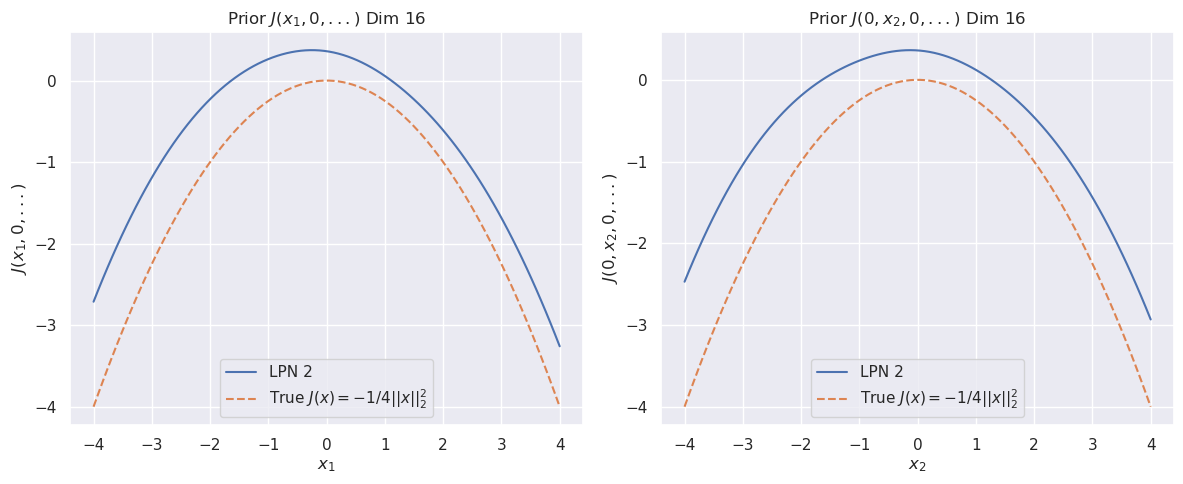

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)